# Testing LR and GWR on the existing data

## Import packages

In [46]:
import pandas as pd
import libpysal
import matplotlib.pyplot as plt
import mgwr
import numpy as np
import pysal
from pysal import model
import geopandas as gpd

## Import shapefile

Download and read MSOA shapefile data.

If the MSOA shapefile is not there, run the next cell to download it.

In [26]:
# note that this dataset contains all 7201 MSOAs in England. This dataset is used as it contains the high resolution boundary and neighbour topology of MSOAs 
# url = 'https://github.com/jreades/fsds/raw/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip'

#! wget $url

In [27]:
# path_data_folder = '../Data'
gdf = gpd.read_file(f"../Data/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip!Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2.shp")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7201 entries, 0 to 7200
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    7201 non-null   int64   
 1   MSOA11CD    7201 non-null   object  
 2   MSOA11NM    7201 non-null   object  
 3   MSOA11NMW   7201 non-null   object  
 4   BNG_E       7201 non-null   int64   
 5   BNG_N       7201 non-null   int64   
 6   LONG        7201 non-null   float64 
 7   LAT         7201 non-null   float64 
 8   Shape__Are  7201 non-null   float64 
 9   Shape__Len  7201 non-null   float64 
 10  geometry    7201 non-null   geometry
dtypes: float64(4), geometry(1), int64(3), object(3)
memory usage: 619.0+ KB


In [28]:
gdf.crs

<Projected CRS: EPSG:27700>
Name: OSGB 1936 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: OSGB 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

## Import uptake data

In [29]:
# import df_uptake data
df_uptake = pd.read_csv("../accessibility_imd_ethnic_exclude.csv")

In [30]:
df_uptake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5808 entries, 0 to 5807
Data columns (total 33 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   MSOA11CD                                             5808 non-null   object 
 1   2sfca_10                                             5808 non-null   float64
 2   2sfca_15                                             5808 non-null   float64
 3   2sfca_20                                             5808 non-null   float64
 4   2sfca_25                                             5808 non-null   float64
 5   2sfca_30                                             5808 non-null   float64
 6   E2sfca_10                                            5808 non-null   float64
 7   E2sfca_15                                            5808 non-null   float64
 8   E2sfca_20                                            5808 non-null  

In [31]:
# one-hot encoding of MSOADECILE
df_uptake = pd.get_dummies(df_uptake, prefix=['MSOADECILE'], columns=['MSOADECILE'])

In [32]:
df_uptake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5808 entries, 0 to 5807
Data columns (total 42 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   MSOA11CD                                             5808 non-null   object 
 1   2sfca_10                                             5808 non-null   float64
 2   2sfca_15                                             5808 non-null   float64
 3   2sfca_20                                             5808 non-null   float64
 4   2sfca_25                                             5808 non-null   float64
 5   2sfca_30                                             5808 non-null   float64
 6   E2sfca_10                                            5808 non-null   float64
 7   E2sfca_15                                            5808 non-null   float64
 8   E2sfca_20                                            5808 non-null  

In [33]:
df_uptake['vaccination_percentage_2nddose'].head()

0    0.955907
1    0.938262
2    0.861435
3    0.884164
4    0.819918
Name: vaccination_percentage_2nddose, dtype: float64

In [34]:
df_uptake.columns

Index(['MSOA11CD', '2sfca_10', '2sfca_15', '2sfca_20', '2sfca_25', '2sfca_30',
       'E2sfca_10', 'E2sfca_15', 'E2sfca_20', 'E2sfca_25', 'E2sfca_30',
       '3sfca_10', '3sfca_15', '3sfca_20', '3sfca_25', '3sfca_30',
       'IMD19 SCORE', 'White%', 'Mixed%', 'Asian%', 'Black%', 'Other%',
       'Per_cent_of_households_with_at_least_one_car_or_van', 'geometry',
       'pop0_17', 'pop18over', 'MSOA', '18over1st_dose', '18over2nd_dose',
       'vaccination_percentage_1stdose', 'vaccination_percentage_2nddose',
       'vaccination_percentage_total', 'MSOADECILE_1', 'MSOADECILE_2',
       'MSOADECILE_3', 'MSOADECILE_4', 'MSOADECILE_5', 'MSOADECILE_6',
       'MSOADECILE_7', 'MSOADECILE_8', 'MSOADECILE_9', 'MSOADECILE_10'],
      dtype='object')

<AxesSubplot:>

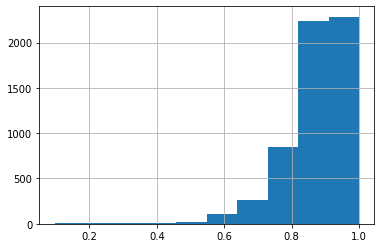

In [35]:
df_uptake.vaccination_percentage_2nddose.hist()

In [36]:
df_uptake.filter(regex='(sfca_|vaccination_percentage_2nddose)').corr()

,2sfca_10,2sfca_15,2sfca_20,2sfca_25,2sfca_30,E2sfca_10,E2sfca_15,E2sfca_20,E2sfca_25,E2sfca_30,3sfca_10,3sfca_15,3sfca_20,3sfca_25,3sfca_30,vaccination_percentage_2nddose
2sfca_10,1.000000,0.718586,0.611596,0.566868,0.554371,0.762692,0.880111,0.883151,0.835954,0.781565,0.687680,0.803996,0.851372,0.852234,0.828762,-0.108869
2sfca_15,0.718586,1.000000,0.837007,0.754537,0.700000,0.583309,0.744769,0.861192,0.911838,0.915986,0.535955,0.650538,0.727109,0.788295,0.832134,-0.099452
2sfca_20,0.611596,0.837007,1.000000,0.898059,0.817505,0.509658,0.644825,0.764988,0.857177,0.909956,0.468091,0.584005,0.664770,0.721647,0.771173,-0.116378
2sfca_25,0.566868,0.754537,0.898059,1.000000,0.926222,0.468209,0.594435,0.699457,0.787914,0.856030,0.433002,0.549481,0.638860,0.696216,0.734530,-0.107809
2sfca_30,0.554371,0.700000,0.817505,0.926222,1.000000,0.463524,0.579312,0.666336,0.737766,0.799299,0.428467,0.543311,0.630177,0.686089,0.717126,-0.099435
E2sfca_10,0.762692,0.583309,0.509658,0.468209,0.463524,1.000000,0.934337,0.833442,0.742489,0.671800,0.940787,0.950224,0.894640,0.822118,0.755127,-0.220133
E2sfca_15,0.880111,0.744769,0.644825,0.594435,0.579312,0.934337,1.000000,0.965459,0.898351,0.832845,0.826719,0.916007,0.939485,0.919633,0.881398,-0.212181
E2sfca_20,0.883151,0.861192,0.764988,0.699457,0.666336,0.833442,0.965459,1.000000,0.978420,0.936260,0.726643,0.839639,0.899752,0.920643,0.918488,-0.203119
E2sfca_25,0.835954,0.911838,0.857177,0.787914,0.737766,0.742489,0.898351,0.978420,1.000000,0.987210,0.647895,0.766500,0.840791,0.883532,0.906721,-0.196973
E2sfca_30,0.781565,0.915986,0.909956,0.856030,0.799299,0.671800,0.832845,0.936260,0.987210,1.000000,0.589093,0.708720,0.789370,0.842350,0.878542,-0.190092


The difference between FCA scores is negligible. Therefore, focus on E2SFCA with bandwidth = 10 miles.

## Creating queen's weight matrix

In [37]:
# gdf: only keep the MSOAs in the df_uptake
gdf_england_no_London = gdf.loc[gdf.MSOA11CD.isin(df_uptake.MSOA)]
# Calculating neighbours based on the Queen's contiguity
wq = libpysal.weights.Queen.from_dataframe(gdf_england_no_London)

/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
 There is 1 island with id: 5688.
  warnings.warn(message)


<AxesSubplot:>

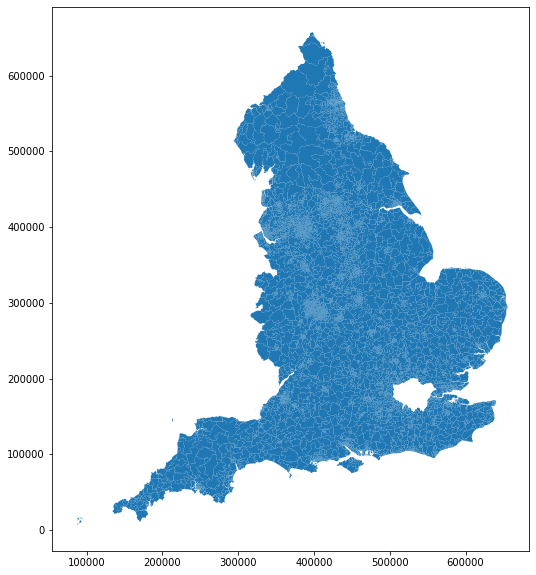

In [38]:
# Now we can visualise the weights in the map
f, ax = plt.subplots(1,1, figsize=(10,10))
gdf_england_no_London.plot(ax=ax)
# wq.plot(gdf_england_no_London, ax=ax)

## Linear regression

In [39]:
# linear regression
import statsmodels.formula.api as sm
# simple linear model - only the access
lr_access = sm.ols(formula="vaccination_percentage_2nddose ~ Q('E2sfca_10')", data=df_uptake).fit()
print(lr_access.summary())

                                  OLS Regression Results                                  
Dep. Variable:     vaccination_percentage_2nddose   R-squared:                       0.048
Model:                                        OLS   Adj. R-squared:                  0.048
Method:                             Least Squares   F-statistic:                     295.7
Date:                            Fri, 04 Mar 2022   Prob (F-statistic):           1.13e-64
Time:                                    17:50:46   Log-Likelihood:                 5534.7
No. Observations:                            5808   AIC:                        -1.107e+04
Df Residuals:                                5806   BIC:                        -1.105e+04
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
-------

In [40]:
lr_2 = sm.ols(formula="vaccination_percentage_2nddose ~ MSOADECILE_2 + MSOADECILE_3 + MSOADECILE_4 + MSOADECILE_5 + MSOADECILE_6 + MSOADECILE_7 + MSOADECILE_8 + MSOADECILE_9 + MSOADECILE_10 + Q('E2sfca_10')  + Per_cent_of_households_with_at_least_one_car_or_van + Q('Mixed%') + Q('Asian%') + Q('Black%') + Q('Other%')", data=df_uptake).fit()
print(lr_2.summary())

                                  OLS Regression Results                                  
Dep. Variable:     vaccination_percentage_2nddose   R-squared:                       0.630
Model:                                        OLS   Adj. R-squared:                  0.629
Method:                             Least Squares   F-statistic:                     656.7
Date:                            Fri, 04 Mar 2022   Prob (F-statistic):               0.00
Time:                                    17:50:46   Log-Likelihood:                 8275.7
No. Observations:                            5808   AIC:                        -1.652e+04
Df Residuals:                                5792   BIC:                        -1.641e+04
Df Model:                                      15                                         
Covariance Type:                        nonrobust                                         
                                                          coef    std err          t      

How about a modle without access score?

In [41]:
lr_3 = sm.ols(formula="vaccination_percentage_2nddose ~ MSOADECILE_2 + MSOADECILE_3 + MSOADECILE_4 + MSOADECILE_5 + MSOADECILE_6 + MSOADECILE_7 + MSOADECILE_8 + MSOADECILE_9 + MSOADECILE_10 + Per_cent_of_households_with_at_least_one_car_or_van + Q('Mixed%') + Q('Asian%') + Q('Black%') + Q('Other%')", data=df_uptake).fit()
print(lr_2.summary())

                                  OLS Regression Results                                  
Dep. Variable:     vaccination_percentage_2nddose   R-squared:                       0.630
Model:                                        OLS   Adj. R-squared:                  0.629
Method:                             Least Squares   F-statistic:                     656.7
Date:                            Fri, 04 Mar 2022   Prob (F-statistic):               0.00
Time:                                    17:50:46   Log-Likelihood:                 8275.7
No. Observations:                            5808   AIC:                        -1.652e+04
Df Residuals:                                5792   BIC:                        -1.641e+04
Df Model:                                      15                                         
Covariance Type:                        nonrobust                                         
                                                          coef    std err          t      

## OLS using mgwr package

In [110]:
# First, you need to prepare the dataset so it can be processed in pysal
uptake_rate = df_uptake['vaccination_percentage_2nddose']
# OLS class requires data to be passed as numpy array
y = np.array(uptake_rate)
# PySAL requires your dependent variable to be nx1 numpy array
y.shape = (len(uptake_rate),1)

In [111]:
# Now prepare your independent variables
X = []
list_x_var = ['MSOADECILE_2' , 'MSOADECILE_3' , 'MSOADECILE_4' , 'MSOADECILE_5' , 'MSOADECILE_6' , 'MSOADECILE_7' , 'MSOADECILE_8' , 'MSOADECILE_9' , 'MSOADECILE_10', \
 'E2sfca_10'  , 'Per_cent_of_households_with_at_least_one_car_or_van' , 'Mixed%' , 'Asian%' , 'Black%' , 'Other%']
for x_var in list_x_var:
    X.append(df_uptake[x_var])
# PySAL requires your independent variable to be a 2D nxj numpy array where j is the number of independent variables
X=np.array(X).T

In [112]:
# OLS regression
ols = pysal.model.spreg.OLS(y, X, w = wq, 
                            spat_diag=True,
                            moran=True,
                            name_y='vaccine_uptake',
                            name_x=list_x_var,
                            name_ds='England', 
                            white_test=True)
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     England
Weights matrix      :     unknown
Dependent Variable  :vaccine_uptake                Number of Observations:        5808
Mean dependent var  :      0.8697                Number of Variables   :          16
S.D. dependent var  :      0.0957                Degrees of Freedom    :        5792
R-squared           :      0.6297
Adjusted R-squared  :      0.6288
Sum squared residual:      19.675                F-statistic           :    656.7228
Sigma-square        :       0.003                Prob(F-statistic)     :           0
S.E. of regression  :       0.058                Log likelihood        :    8275.651
Sigma-square ML     :       0.003                Akaike info criterion :  -16519.302
S.E of regression ML:      0.0582                Schwarz criterion     :  -16412.630

---------------------------------------------------------------------------

In [113]:
# vif
vif_ols = pysal.model.spreg.vif(ols)
# max vif
print(np.max(vif_ols[1:]))
print(vif_ols)

4.547125165761353
[None, (1.8443879854224745, 0.5421852711597124), (2.0765272640759806, 0.4815732580544677), (2.446518955541841, 0.4087440229043824), (2.80647094755096, 0.3563193842689305), (3.1263469033280846, 0.3198621365196139), (3.646975092276993, 0.2741998436231844), (3.84498228293063, 0.26007922180536136), (3.981920286443722, 0.25113511272550015), (4.487495930457467, 0.22284142771312943), (1.1135569454533727, 0.8980232255593007), (4.547125165761353, 0.21991917168450403), (2.8136554808287944, 0.35540953994319113), (1.6645972292045224, 0.6007459236718061), (2.763249523859965, 0.36189276117312297), (2.152854851039486, 0.46449949912654787)]


Analysis of Moran's I

in this OLS, the Moran’s I of the residuals is 0.317 with a standardized value of40.748 and a p-value of 0.0000

In [49]:
print("Moran's I value:")
print(round(ols.moran_res[0],3))
print(round(ols.moran_res[1],3))
print(round(ols.moran_res[2],4))

Moran's I value:
0.317
40.748
0.0


TODO: mapping of residual (to show spatial autocorrelation. May colour MSOAs using Quardrat of Moran's I values)

## GWR

Make sure that all MOSAs in df_uptake are contained in gdf.

In [52]:
gdf.MSOA11CD.head()

0    E02000001
1    E02000002
2    E02000003
3    E02000004
4    E02000005
Name: MSOA11CD, dtype: object

In [53]:
df_uptake.MSOA.head()

0    E02000984
1    E02000985
2    E02000986
3    E02000987
4    E02000988
Name: MSOA, dtype: object

In [54]:
df_uptake.MSOA.isin(gdf.MSOA11CD).all()

True

Will use the k nearest neighbours to build the GWR. See [this tutorial](https://github.com/zarashabrina/gwr-mgwr-tutorial-stopsearch/blob/master/Stop-search%20GWR%20MGWR%20analysis.ipynb).

Here are the steps of GWR.

### Data preparation

In [55]:
# add coords to df_uptake by linking to gdf_england_no_London
df_uptake = df_uptake.merge(gdf_england_no_London[['MSOA11CD', 'BNG_E', 'BNG_N']], left_on = 'MSOA', right_on='MSOA11CD', how='left')
df_uptake.columns

Index(['MSOA11CD_x', '2sfca_10', '2sfca_15', '2sfca_20', '2sfca_25',
       '2sfca_30', 'E2sfca_10', 'E2sfca_15', 'E2sfca_20', 'E2sfca_25',
       'E2sfca_30', '3sfca_10', '3sfca_15', '3sfca_20', '3sfca_25', '3sfca_30',
       'IMD19 SCORE', 'White%', 'Mixed%', 'Asian%', 'Black%', 'Other%',
       'Per_cent_of_households_with_at_least_one_car_or_van', 'geometry',
       'pop0_17', 'pop18over', 'MSOA', '18over1st_dose', '18over2nd_dose',
       'vaccination_percentage_1stdose', 'vaccination_percentage_2nddose',
       'vaccination_percentage_total', 'MSOADECILE_1', 'MSOADECILE_2',
       'MSOADECILE_3', 'MSOADECILE_4', 'MSOADECILE_5', 'MSOADECILE_6',
       'MSOADECILE_7', 'MSOADECILE_8', 'MSOADECILE_9', 'MSOADECILE_10',
       'MSOA11CD_y', 'BNG_E', 'BNG_N'],
      dtype='object')

In [56]:
#Prepare dataset inputs
g_y = df_uptake['vaccination_percentage_2nddose'].values.reshape((-1,1))
g_X = df_uptake[['MSOADECILE_2' , 'MSOADECILE_3' , 'MSOADECILE_4' , 'MSOADECILE_5' , 'MSOADECILE_6' , 'MSOADECILE_7' , 'MSOADECILE_8' , 'MSOADECILE_9' , 'MSOADECILE_10', \
 'E2sfca_10'  , 'Per_cent_of_households_with_at_least_one_car_or_van' , 'Mixed%' , 'Asian%' , 'Black%' , 'Other%']].values
# g_X = df_uptake[[ \
#  'E2sfca_10']].values

u = df_uptake['BNG_E'].astype(float)
v = df_uptake['BNG_N'].astype(float)
g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

g_X = np.array(g_X).astype(float)
g_y = np.array(g_y).astype(float)

In [57]:
print(g_X)

[[-0.32147078 -0.31059572 -0.31885607 ... -0.35487421 -0.48217299
  -0.35036516]
 [-0.32147078 -0.31059572 -0.31885607 ... -0.42280522 -0.42951927
  -0.44314976]
 [-0.32147078 -0.31059572 -0.31885607 ...  0.39916003 -0.35053868
  -0.11324897]
 ...
 [-0.32147078 -0.31059572  3.13621123 ...  1.18036667  0.29446944
   3.44349392]
 [-0.32147078  3.21961941 -0.31885607 ...  0.20313054  0.44913976
   3.57751612]
 [-0.32147078 -0.31059572 -0.31885607 ...  0.30502705  0.33395974
   4.0208203 ]]


In [58]:
# check for NaN or Inf value
print(np.isnan(g_X).any() or np.isinf(g_X).any())
print(np.isnan(g_y).any() or np.isinf(g_y).any())
print(np.isnan(g_coords).any() or np.isinf(g_coords).any())

False
False
False


### Select the bandwidth

Test the example from [here](https://pysal.org/notebooks/model/mgwr/GWR_MGWR_example.html).

In [59]:
# test the example

import numpy as np
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR, MGWR
import pandas as pd
import libpysal as ps

data = ps.io.open(ps.examples.get_path('GData_utm.csv'))
coords = list(zip(data.by_col('X'), data.by_col('Y')))
y = np.array(data.by_col('PctBach')).reshape((-1,1))
rural  = np.array(data.by_col('PctRural')).reshape((-1,1))
pov = np.array(data.by_col('PctPov')).reshape((-1,1)) 
black = np.array(data.by_col('PctBlack')).reshape((-1,1))
fb = np.array(data.by_col('PctFB')).reshape((-1,1))
pop = np.array(data.by_col('TotPop90')).reshape((-1,1))


X = np.hstack([fb, black, rural])

X = (X - X.mean(axis=0)) / X.std(axis=0)

y = y.reshape((-1,1))

y = (y - y.mean(axis=0)) / y.std(axis=0)

sel = Sel_BW(coords, y, X)

bw = sel.search()
print('bw:', bw)
gwr = GWR(coords, y, X, bw)
gwr_results = gwr.fit()
print('aicc:', gwr_results.aicc)
print('ENP:', gwr_results.ENP)
print('sigma2:', gwr_results.sigma2)

bw: 117.0
aicc: 299.0508086830288
ENP: 11.804769716730094
sigma2: 0.3477435474978281


mgwr.sel_bw.Sel_BW() works for the first 1000 rows.

In [60]:
# Select bandwidth for kernel
max_ind = 1000
# set it as None if all rows are used

bw = mgwr.sel_bw.Sel_BW(g_coords[:max_ind], 
                  g_y[:max_ind], # Dependent variable
                  g_X[:max_ind], # Independent variable
                  fixed=False)

In [61]:
%%time
bw.search()

CPU times: user 4min 19s, sys: 15min 53s, total: 20min 13s
Wall time: 1min 15s


644.0

Get an error of `LinAlgError` when all rows are used. 

Possible reason: there may be local clusters of similar values.

Possible solution: increase the bw_min.

Using bw_min = 100. **Does it work?** Yes.

In [191]:
# Select bandwidth for kernel
bw = mgwr.sel_bw.Sel_BW(g_coords, 
                  g_y, # Dependent variable
                  g_X, # Independent variable
                  fixed=False)

In [192]:
%%time
# search the optimum bandwidth for our local regression?
# import warnings
# warnings.filterwarnings("ignore")
bw.search(bw_min=100)

CPU times: user 45min 53s, sys: 2h 37min 11s, total: 3h 23min 4s
Wall time: 12min 42s


442.0

In [193]:
bw.bw[0]

442.0

### Build the model

In [62]:
# Building the Geographically Weighted Regression Model
model = mgwr.gwr.GWR(g_coords, # a collection of n sets of x and y coordinates
                     g_y, # dependent variable
                     g_X, # independent variables
                     bw.bw[0]) # bandwidth value  ( we use N nearest neighbours)

In [63]:
%%time
# Fit the model with particular estimations 
results = model.fit()
results.summary()

/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=2.07942e-18): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=8.6032e-19): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=6.0415e-19): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=1.21956e-17): result may not be accurate.
  xtx_inv_xt = linalg.solve(xtx, xT)
/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/spglm/iwls.py:37: LinAlgWarning: Ill-conditioned matrix (rcond=4.31535e-18): result may not be accurate.
  xt

Model type                                                         Gaussian
Number of observations:                                                5808
Number of covariates:                                                    16

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2150.500
Log-likelihood:                                                   -5355.967
AIC:                                                              10743.934
AICc:                                                             10746.040
BIC:                                                             -48048.715
R2:                                                                   0.630
Adj. R2:                                                              0.629

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Testing the spatial autocorrelation of residuals

In [81]:
results.resid_response

array([-0.04407314,  0.16641146, -0.24329201, ..., -0.6619459 ,
       -0.77344224, -2.99019583])

In [75]:
import esda

In [77]:
mi = esda.moran.Moran(results.resid_response, w=wq, two_tailed=False)

# pysal.model.spreg.diagnostics_sp.MoranRes(, w=wq)

('WARNING: ', 5688, ' is an island (no neighbors)')


In [88]:
print("P value under normality assumption:")
print("%.5f"%mi.p_norm)
print("P value via permutation:")
print("%.5f"%mi.p_sim)
print("P value under randomization assumption:")
print("%.5f"%mi.p_rand)

P value under normality assumption:
0.00000
P value via permutation:
0.00100
P value under randomization assumption:
0.00000


From our GWR model, we can get the local estimates as well as local R2.

It is important in GWR that we only include statistically significant estimates (in our case, we will assign 95% confidence intervals, thus the p-value of our local estimates need to be lower than 0.05.

Luckily, mgwr package has a method to extract only a filtered set of significant local estimates by assigning 0 for local estimates that are not significant using filter_tval.

In [95]:
# Filtering only significant result at 0.05 (95% confidence interval)
filtered_estimates = results.filter_tvals(alpha=.05)
filtered_estimates

# Can you check the estimates using 99% and 90% confidence interval
filtered_estimates90 = results.filter_tvals(alpha=.1)
filtered_estimates99 = results.filter_tvals(alpha=.01)

### Visualising the results

In [96]:
# Convert arrays to data frame
data_params = pd.DataFrame(filtered_estimates)
data_localR2 = pd.DataFrame(results.localR2)
data_resid = pd.DataFrame(results.resid_response)

In [97]:
list_x_var

['MSOADECILE_2',
 'MSOADECILE_3',
 'MSOADECILE_4',
 'MSOADECILE_5',
 'MSOADECILE_6',
 'MSOADECILE_7',
 'MSOADECILE_8',
 'MSOADECILE_9',
 'MSOADECILE_10',
 'E2sfca_10',
 'Per_cent_of_households_with_at_least_one_car_or_van',
 'Mixed%',
 'Asian%',
 'Black%',
 'Other%']

In [98]:
# Create the new dataframe
df1=pd.DataFrame(df_uptake["MSOA"])
df2 = df1.assign(intercept=data_params[0],
                 IMD_DC_2=data_params[1],
                 IMD_DC_3=data_params[2],
                 IMD_DC_4=data_params[3],
                 IMD_DC_5=data_params[4],
                 IMD_DC_6=data_params[5],
                 IMD_DC_7=data_params[6],
                 IMD_DC_8=data_params[7],
                 IMD_DC_9=data_params[8],
                 IMD_DC_10=data_params[9],
                 accessibility=data_params[10],
                 pct_hh_car=data_params[11],
                 eth_mixed=data_params[12],
                 eth_asian=data_params[13],
                 eth_black=data_params[14],
                 eth_other=data_params[15],
                 resid = data_resid[0],
                 localR2=data_localR2[0])
df2.columns
df2

,MSOA,intercept,IMD_DC_2,IMD_DC_3,IMD_DC_4,IMD_DC_5,IMD_DC_6,IMD_DC_7,IMD_DC_8,IMD_DC_9,IMD_DC_10,accessibility,pct_hh_car,eth_mixed,eth_asian,eth_black,eth_other,resid,localR2
0,E02000984,-3.210965,0.000000,-2.056952,-2.469861,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,9.047094,0.000000,0.000000,2.386919,-2.631787,-0.044073,0.748421
1,E02000985,-2.448034,-2.541754,-2.771812,-3.391385,-2.446430,0.000000,-2.115802,0.000000,0.0,0.0,0.0,10.568596,0.000000,0.000000,2.659794,-3.035596,0.166411,0.735768
2,E02000986,-2.747706,-2.310722,-2.515429,-3.125701,-2.255349,0.000000,0.000000,0.000000,0.0,0.0,0.0,10.152463,0.000000,0.000000,2.545259,-2.918091,-0.243292,0.740732
3,E02000987,-3.833916,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,7.299982,0.000000,0.000000,0.000000,0.000000,0.665085,0.757659
4,E02000988,-2.580994,-2.388102,-2.571491,-3.291392,-2.379745,0.000000,-2.034841,0.000000,0.0,0.0,0.0,10.416928,0.000000,0.000000,2.510537,-2.971195,0.114473,0.740125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5803,E02006922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,5.112996,2.355398,0.000000,-7.488772,-5.005037,0.349467,0.700019
5804,E02006926,-3.948951,2.028618,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,4.530894,-2.200823,0.000000,-7.322580,-2.582811,0.429830,0.810937
5805,E02006932,-3.845362,-2.462869,-2.857466,-2.949665,-3.153144,-2.499047,0.000000,-2.199424,0.0,0.0,0.0,10.492138,0.000000,-6.191331,0.000000,0.000000,-0.661946,0.792805
5806,E02006933,-3.847725,-2.414255,-2.817132,-2.922856,-3.098706,-2.482580,0.000000,-2.141526,0.0,0.0,0.0,10.485916,0.000000,-6.205475,0.000000,0.000000,-0.773442,0.793655


Merge the GWR results with the shapefile.

In [99]:
# Merge our shapefile with the model's results
gdf_gwr_result = gdf_england_no_London.merge(df2, left_on='MSOA11CD', right_on='MSOA')
gdf_gwr_result.head()

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,...,IMD_DC_9,IMD_DC_10,accessibility,pct_hh_car,eth_mixed,eth_asian,eth_black,eth_other,resid,localR2
0,952,E02000984,Bolton 001,Bolton 001,370496,414294,-2.44755,53.62435,7.900020e+06,17881.651425,...,0.0,0.0,0.0,9.047094,0.0,0.0,2.386919,-2.631787,-0.044073,0.748421
1,953,E02000985,Bolton 002,Bolton 002,373170,413001,-2.40701,53.61288,3.702707e+06,14402.331728,...,0.0,0.0,0.0,10.568596,0.0,0.0,2.659794,-3.035596,0.166411,0.735768
2,954,E02000986,Bolton 003,Bolton 003,371724,412733,-2.42884,53.61039,1.924288e+06,9817.341757,...,0.0,0.0,0.0,10.152463,0.0,0.0,2.545259,-2.918091,-0.243292,0.740732
3,955,E02000987,Bolton 004,Bolton 004,363867,411815,-2.54749,53.60166,1.571885e+06,7694.576899,...,0.0,0.0,0.0,7.299982,0.0,0.0,0.000000,0.000000,0.665085,0.757659
4,956,E02000988,Bolton 005,Bolton 005,371364,411523,-2.43417,53.59950,1.951362e+06,10354.056360,...,0.0,0.0,0.0,10.416928,0.0,0.0,2.510537,-2.971195,0.114473,0.740125


In [119]:
np.min(df2.resid)

-5.2941530742438605

<AxesSubplot:>

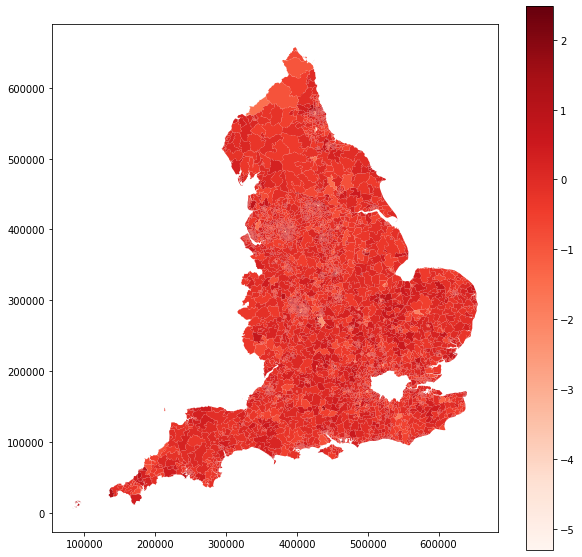

In [125]:
# visualise the residuals
# f,ax=plt.subplots(2,3,figsize=(15,6), subplot_kw=dict(aspect='equal'))
# # Flatten them
# ax = ax.flatten()

# (gdf_gwr_result.assign(resid=df2.resid)
#  .sort_values('resid')
#  .plot('resid',
#        ax=ax,
#        legend=True,
#        vmin=np.min(df2.resid),
#        vmax=np.max(df2.resid),
#        cmap='Reds'))
    
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# ax.set_xticks([])
# ax.set_yticks([])

# ax.set_title('residual', fontsize=16)
    
# f.tight_layout()
    
# plt.show()

# the following codes are useful
f, ax = plt.subplots(1,1, figsize=(10,10))
gwr_resid = results.resid_response
gdf_england_no_London.assign(resid=gwr_resid).plot('resid',
       ax=ax,
       legend=True,
       vmin=np.min(gwr_resid),
       vmax=np.max(gwr_resid),
       cmap='Reds')

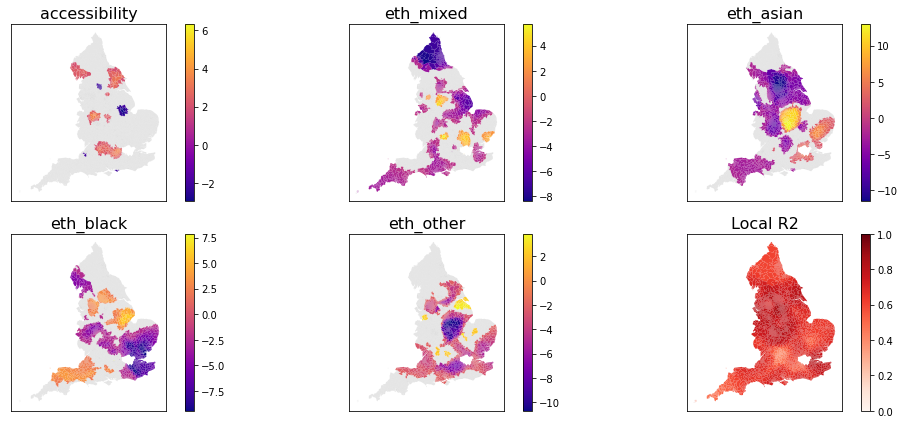

In [101]:
# First, let's create empty set of subplots with 2 rows and 3 columns
f,ax=plt.subplots(2,3,figsize=(15,6), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots
titles = ['accessibility','eth_mixed', 'eth_asian', 'eth_black', 'eth_other']

subset_filtered_estimates = np.array(df2[titles])
# Here, we are creating loop for our parameter estimates 
for i,row in enumerate(subset_filtered_estimates.T):
    # We want to plot all the non-significant estimates in grey
    ct_temp = gdf_gwr_result.assign(toplot=subset_filtered_estimates.T[i])
    (ct_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    # and assign colours only to the significant estimates
    (ct_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='plasma',
           ax=ax[i],
           legend=True))
    
    ax[i].set_title(titles[i], fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
 
# For the last one, local R2, we can just map all of them regarding the significance

(gdf_gwr_result.assign(r2=df2.localR2)
 .sort_values('r2')
 .plot('r2',
       ax=ax[-1],
       legend=True,
       vmin=0,
       vmax=1,
       cmap='Reds'))
    
ax[-1].set_xticklabels([])
ax[-1].set_yticklabels([])
ax[-1].set_xticks([])
ax[-1].set_yticks([])
    
ax[-1].set_title('Local R2', fontsize=16)
    
f.tight_layout()
    
plt.show()


In [226]:
df2.columns

Index(['MSOA', 'intercept', 'IMD_DC_2', 'IMD_DC_3', 'IMD_DC_4', 'IMD_DC_5',
       'IMD_DC_6', 'IMD_DC_7', 'IMD_DC_8', 'IMD_DC_9', 'IMD_DC_10',
       'accessibility', 'pct_hh_car', 'eth_mixed', 'eth_asian', 'eth_black',
       'eth_other', 'localR2'],
      dtype='object')

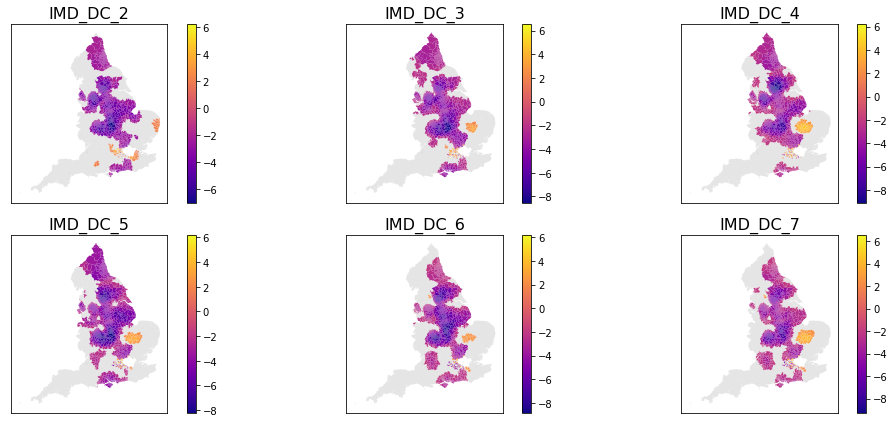

In [227]:
# First, let's create empty set of subplots with 2 rows and 3 columns
f,ax=plt.subplots(2,3,figsize=(15,6), subplot_kw=dict(aspect='equal'))
# Flatten them
ax = ax.flatten()
# Define the title of our plots
titles = ['IMD_DC_2','IMD_DC_3', 'IMD_DC_4', 'IMD_DC_5', 'IMD_DC_6', 'IMD_DC_7']

subset_filtered_estimates = np.array(df2[titles])
# Here, we are creating loop for our parameter estimates 
for i,row in enumerate(subset_filtered_estimates.T):
    # We want to plot all the non-significant estimates in grey
    ct_temp = gdf_gwr_result.assign(toplot=subset_filtered_estimates.T[i])
    (ct_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    # and assign colours only to the significant estimates
    (ct_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='plasma',
           ax=ax[i],
           legend=True))
    
    ax[i].set_title(titles[i], fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
f.tight_layout()
    
plt.show()
